In [39]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# download data from Yahoo Finance
data = yf.download("GC=F", start = '2021-1-1', end = '2023-11-14')
data.to_csv('gold_prices_20210101_20231031.csv')

[*********************100%%**********************]  1 of 1 completed


In [56]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,1912.199951,1945.099976,1912.199951,1944.699951,1944.699951,154
2021-01-05,1941.699951,1952.699951,1941.300049,1952.699951,1952.699951,113
2021-01-06,1952.000000,1959.900024,1901.500000,1906.900024,1906.900024,331
2021-01-07,1922.599976,1926.699951,1912.000000,1912.300049,1912.300049,122
2021-01-08,1908.000000,1908.000000,1834.099976,1834.099976,1834.099976,60
...,...,...,...,...,...,...
2023-11-07,1966.500000,1966.800049,1960.699951,1966.800049,1966.800049,20
2023-11-08,1967.800049,1967.800049,1947.699951,1951.500000,1951.500000,43
2023-11-09,1951.699951,1964.199951,1945.300049,1964.199951,1964.199951,10


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Drop rows with missing values
data_clean = data.dropna()

# We focus on the 'Close' column for volatility calculations
close_prices = data_clean[['Close']].values

# Initialize the MinMaxScaler to scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Split the data into training (90%) and testing (10%) sets
train_data, test_data = train_test_split(scaled_data, train_size=0.9, test_size=0.1, shuffle=False)

len(train_data), len(test_data)

(648, 73)

In [58]:
def calculate_daily_returns(prices):
    returns = np.diff(prices, axis=0) / prices[:-1]
    return returns

# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]  
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Calculate daily returns
daily_returns = calculate_daily_returns(train_data)

# Calculate rolling variance with a window of 261 days
window_length = 261
variance = pd.Series(daily_returns.flatten()).rolling(window=window_length).var().dropna().values

# Scale the variance data to be between 0 and 1
scaled_variance = scaler.fit_transform(variance.reshape(-1, 1))

# Create the LSTM dataset
time_step = 1  # Using 1 day lagged variance to predict current day's variance
X_train, y_train = create_dataset(scaled_variance, time_step)

X_train.shape, y_train.shape

/var/folders/b8/djnfc_v15770s0g45ydyl4vw0000gp/T/ipykernel_97277/1283229574.py:2: RuntimeWarning: divide by zero encountered in divide
  returns = np.diff(prices, axis=0) / prices[:-1]


((173, 1), (173,))

In [59]:
X_train

array([[7.57786520e-01],
       [7.57906799e-01],
       [7.60258362e-01],
       [7.60187869e-01],
       [7.21821468e-01],
       [7.20329406e-01],
       [7.20702526e-01],
       [7.25532095e-01],
       [7.42748898e-01],
       [7.39320780e-01],
       [7.40013552e-01],
       [7.33173974e-01],
       [7.34226728e-01],
       [7.33952182e-01],
       [7.34032623e-01],
       [7.36395926e-01],
       [7.36215163e-01],
       [7.36181833e-01],
       [7.35428244e-01],
       [7.34001398e-01],
       [7.32049408e-01],
       [7.33960092e-01],
       [7.11800527e-01],
       [7.10621378e-01],
       [7.04982846e-01],
       [7.05152899e-01],
       [7.04990418e-01],
       [7.02918694e-01],
       [7.12185068e-01],
       [7.04198218e-01],
       [7.02473112e-01],
       [7.05474540e-01],
       [7.06155763e-01],
       [6.90666678e-01],
       [6.93453143e-01],
       [6.98998641e-01],
       [6.99423536e-01],
       [6.47329115e-01],
       [6.46581726e-01],
       [6.44597842e-01],


In [60]:
# Identify where the returns are infinite due to division by zero
infinite_returns = np.isinf(daily_returns) | np.isnan(daily_returns)

# Filter out the infinite returns and corresponding prices
daily_returns_filtered = daily_returns[~infinite_returns]
train_data_filtered = train_data[1:][~infinite_returns.flatten()]  # Exclude the first value as diff is computed

# Recalculate rolling variance with a window of 261 days on the filtered data
variance_filtered = pd.Series(daily_returns_filtered.flatten()).rolling(window=window_length).var().dropna().values

# Scale the filtered variance data to be between 0 and 1
scaled_variance_filtered = scaler.fit_transform(variance_filtered.reshape(-1, 1))

# Create the LSTM dataset with the filtered data
X_train_filtered, y_train_filtered = create_dataset(scaled_variance_filtered, time_step)

X_train_filtered.shape, y_train_filtered.shape, train_data_filtered.shape

((384, 1), (384,), (646, 1))

Epoch 1/100
12/12 [==============================] - 1s 2ms/step - loss: 0.2120
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0392
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 4/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 5/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 8/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 9/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 10/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 11/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 12/100
12/12 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 13/100
12/12 [=================

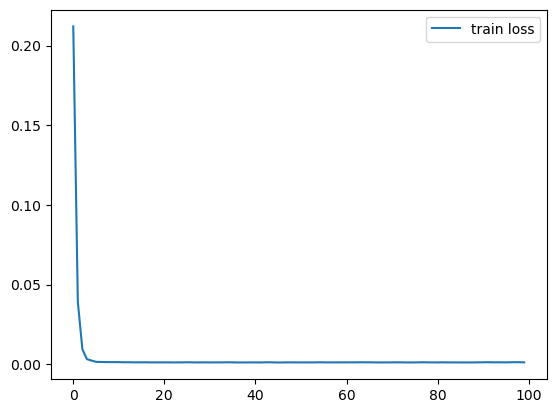

In [61]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model with the Adam optimizer and the mean squared error loss function
model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train_reshaped = X_train_filtered.reshape(X_train_filtered.shape[0], 1, X_train_filtered.shape[1])

# Train the model
history = model.fit(X_train_reshaped, y_train_filtered, epochs=100, batch_size=32, verbose=1)

# Plotting the training loss
plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()

In [62]:
# Predict on training data
train_predict = model.predict(X_train_reshaped)

# Invert predictions and targets to original scale for RMSE computation
train_predict = scaler.inverse_transform(train_predict)
y_train_filtered_original = scaler.inverse_transform([y_train_filtered])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_filtered_original[0], train_predict[:,0]))
print(f'Train RMSE: {train_rmse}')

12/12 [==============================] - 0s 605us/step
Train RMSE: 0.03123684876301921


In [63]:
X_test, y_test = create_dataset(test_data, 1)
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)

3/3 [==============================] - 0s 1ms/step


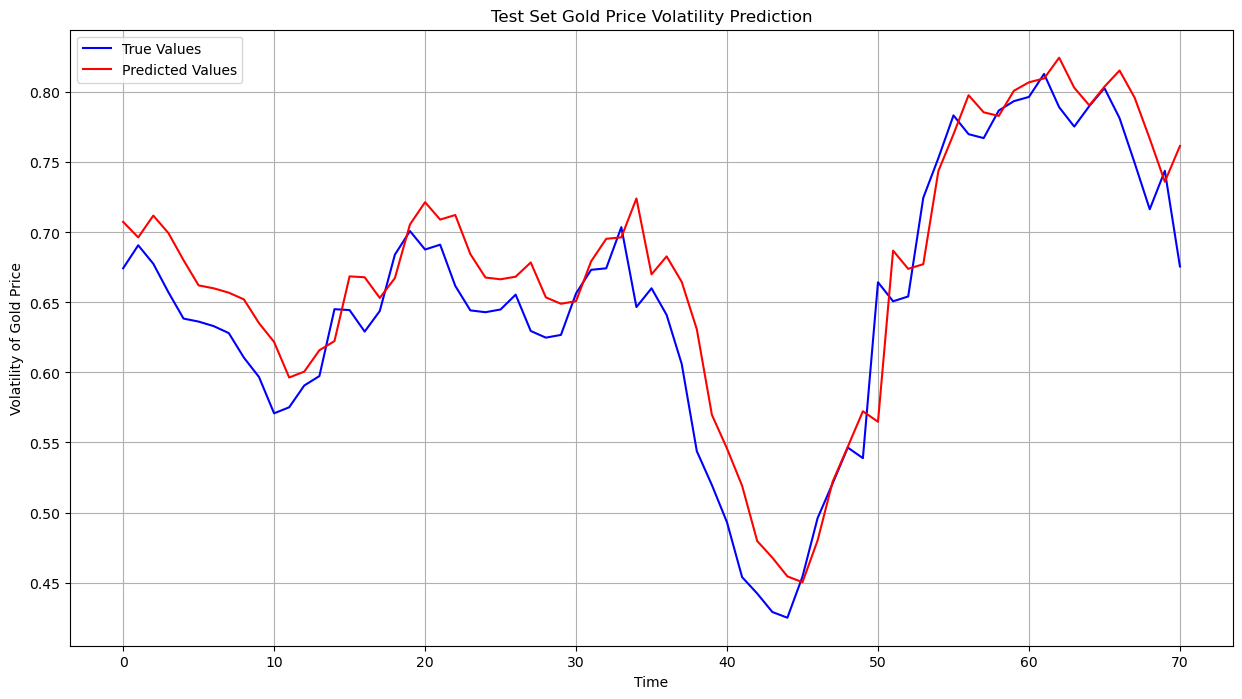

In [64]:
# Make predictions on the test data
test_predict = model.predict(X_test)

# Invert the predictions to original scale
test_predict_original = scaler.inverse_transform(test_predict)

# Invert the true values to their original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(y_test_original, label='True Values', color='blue')
plt.plot(test_predict_original, label='Predicted Values', color='red')
plt.title('Test Set Gold Price Volatility Prediction')
plt.xlabel('Time')
plt.ylabel('Volatility of Gold Price')
plt.legend()
plt.grid()
plt.show()



In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
test_rmse = sqrt(mean_squared_error(y_test_original, test_predict_original))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.036248665196971994


In [66]:
test_predict
len(test_predict)

71

In [67]:
test_predict_original
df = pd.DataFrame(test_predict_original)
df.to_csv('test_predict_original.csv')

In [68]:
daily_returns

array([[ 2.48911090e-02],
       [-1.39040499e-01],
       [ 1.90409904e-02],
       [-2.70588489e-01],
       [ 7.35294373e-02],
       [-2.96065106e-02],
       [ 4.87247375e-02],
       [-1.43288224e-02],
       [-9.25110132e-02],
       [ 4.95143261e-02],
       [ 1.22109299e-01],
       [-2.47310654e-03],
       [-3.96698250e-02],
       [-3.44202708e-03],
       [-1.81350332e-02],
       [-2.55054057e-02],
       [-3.15884511e-02],
       [ 4.38025419e-02],
       [ 6.02678571e-02],
       [-1.27579153e-01],
       [ 8.20439948e-03],
       [-2.07275955e-01],
       [ 1.32850261e-01],
       [ 1.11940313e-01],
       [ 1.62992560e-02],
       [ 2.49996545e-02],
       [-7.22501448e-02],
       [-1.63692918e-02],
       [-1.23046059e-01],
       [-1.50086200e-01],
       [ 1.55619078e-02],
       [ 1.59895057e-02],
       [ 2.02622310e-01],
       [-1.25405015e-02],
       [-4.41744952e-02],
       [-1.27094183e-01],
       [-3.06419962e-01],
       [-5.34349189e-02],
       [ 1.0

In [69]:
test_data

array([[0.73958091],
       [0.72686599],
       [0.74476092],
       [0.7303979 ],
       [0.70826457],
       [0.68777963],
       [0.68542503],
       [0.68189312],
       [0.67647742],
       [0.65740519],
       [0.64233567],
       [0.61408043],
       [0.61878963],
       [0.63574295],
       [0.64304216],
       [0.69507884],
       [0.69437235],
       [0.67765472],
       [0.69366614],
       [0.73746171],
       [0.75582773],
       [0.74146442],
       [0.74523201],
       [0.71320918],
       [0.69413695],
       [0.69272424],
       [0.69484344],
       [0.70638106],
       [0.67812581],
       [0.67294551],
       [0.67506471],
       [0.70732267],
       [0.72568869],
       [0.72686599],
       [0.75888854],
       [0.69672695],
       [0.71132567],
       [0.69060504],
       [0.65246058],
       [0.58464788],
       [0.55827644],
       [0.5293147 ],
       [0.48669643],
       [0.47398152],
       [0.45961849],
       [0.45514469],
       [0.48716724],
       [0.532

In [70]:
y_train_filtered

array([6.06150762e-03, 6.08031470e-03, 6.07975092e-03, 5.77290814e-03,
       5.76097509e-03, 5.76395918e-03, 5.80258461e-03, 5.94027935e-03,
       5.91286231e-03, 5.91840288e-03, 5.86370203e-03, 5.87212163e-03,
       5.86992590e-03, 5.87056924e-03, 5.88947021e-03, 5.88802453e-03,
       5.88775796e-03, 5.88173099e-03, 5.87031951e-03, 5.85470809e-03,
       5.86998916e-03, 5.69276371e-03, 5.68333323e-03, 5.63823798e-03,
       5.63959801e-03, 5.63829853e-03, 5.62172952e-03, 5.69583915e-03,
       5.63196276e-03, 5.61816588e-03, 5.64217039e-03, 5.64761860e-03,
       5.52374163e-03, 5.54602692e-03, 5.59037813e-03, 5.59377630e-03,
       5.17714100e-03, 5.17116361e-03, 5.15529711e-03, 5.07518392e-03,
       4.97283180e-03, 5.01604935e-03, 4.69260469e-03, 2.61413967e-03,
       2.61136168e-03, 2.61962931e-03, 2.63450970e-03, 2.60614878e-03,
       2.61722632e-03, 2.64766397e-03, 2.65787115e-03, 2.64116245e-03,
       2.67739789e-03, 2.61669029e-03, 2.59849780e-03, 2.57292278e-03,
      

In [71]:
test_data


array([[0.73958091],
       [0.72686599],
       [0.74476092],
       [0.7303979 ],
       [0.70826457],
       [0.68777963],
       [0.68542503],
       [0.68189312],
       [0.67647742],
       [0.65740519],
       [0.64233567],
       [0.61408043],
       [0.61878963],
       [0.63574295],
       [0.64304216],
       [0.69507884],
       [0.69437235],
       [0.67765472],
       [0.69366614],
       [0.73746171],
       [0.75582773],
       [0.74146442],
       [0.74523201],
       [0.71320918],
       [0.69413695],
       [0.69272424],
       [0.69484344],
       [0.70638106],
       [0.67812581],
       [0.67294551],
       [0.67506471],
       [0.70732267],
       [0.72568869],
       [0.72686599],
       [0.75888854],
       [0.69672695],
       [0.71132567],
       [0.69060504],
       [0.65246058],
       [0.58464788],
       [0.55827644],
       [0.5293147 ],
       [0.48669643],
       [0.47398152],
       [0.45961849],
       [0.45514469],
       [0.48716724],
       [0.532